In [ ]:
import kagglehub
kagglehub.login()




Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

digit_recognizer_path = kagglehub.competition_download('digit-recognizer')
print(digit_recognizer_path)


100%|██████████| 15.3M/15.3M [00:00<00:00, 109MB/s]

Extracting files...


/root/.cache/kagglehub/competitions/digit-recognizer


In [ ]:
import os

print(digit_recognizer_path)
print("Files in directory:")
print(os.listdir(digit_recognizer_path))


/root/.cache/kagglehub/competitions/digit-recognizer
Files in directory:
['train.csv', 'sample_submission.csv', 'test.csv']


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

data_path = Path(digit_recognizer_path)
train_df = pd.read_csv(data_path / 'train.csv')
test_df = pd.read_csv(data_path / 'test.csv')

train_df.head()



,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Simple MNIST NN from scratch

In this notebook, I implemented a simple two-layer neural network and trained it on the MNIST digit recognizer dataset. It's meant to be an instructional example, through which you can understand the underlying math of neural networks better.

Here's a video I made explaining all the math and showing my progress as I coded the network: https://youtu.be/w8yWXqWQYmU

In [ ]:
import numpy as np

# Convert DataFrame to NumPy array
data = train_df.to_numpy()

# Shuffle and split
m, n = data.shape
np.random.shuffle(data)

# Development set (first 1000 samples)
data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

# Training set (rest of the data)
data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.

_, m_train = X_train.shape


In [ ]:
Y_train

array([9, 7, 9, ..., 1, 5, 3])

Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [ ]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

In [ ]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [ ]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[0 7 0 ... 0 0 5] [9 7 9 ... 1 5 3]
0.0897560975609756
Iteration:  10
[9 7 7 ... 7 5 9] [9 7 9 ... 1 5 3]
0.15258536585365853
Iteration:  20
[9 7 7 ... 7 5 9] [9 7 9 ... 1 5 3]
0.1908780487804878
Iteration:  30
[9 7 7 ... 4 5 9] [9 7 9 ... 1 5 3]
0.2304878048780488
Iteration:  40
[9 7 7 ... 4 5 9] [9 7 9 ... 1 5 3]
0.27890243902439027
Iteration:  50
[9 7 7 ... 4 9 9] [9 7 9 ... 1 5 3]
0.32495121951219513
Iteration:  60
[9 7 7 ... 4 8 9] [9 7 9 ... 1 5 3]
0.37121951219512195
Iteration:  70
[9 7 7 ... 1 8 9] [9 7 9 ... 1 5 3]
0.41217073170731705
Iteration:  80
[9 7 7 ... 1 8 9] [9 7 9 ... 1 5 3]
0.45658536585365855
Iteration:  90
[9 7 7 ... 1 8 9] [9 7 9 ... 1 5 3]
0.4985609756097561
Iteration:  100
[9 7 7 ... 1 9 9] [9 7 9 ... 1 5 3]
0.5393170731707317
Iteration:  110
[9 7 7 ... 1 9 3] [9 7 9 ... 1 5 3]
0.5770243902439024
Iteration:  120
[9 7 9 ... 1 9 3] [9 7 9 ... 1 5 3]
0.6091463414634146
Iteration:  130
[9 7 9 ... 1 5 3] [9 7 9 ... 1 5 3]
0.6380487804878049
Iteration: 

~85% accuracy on training set.

In [ ]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Let's look at a couple of examples:

Prediction:  [9]
Label:  9


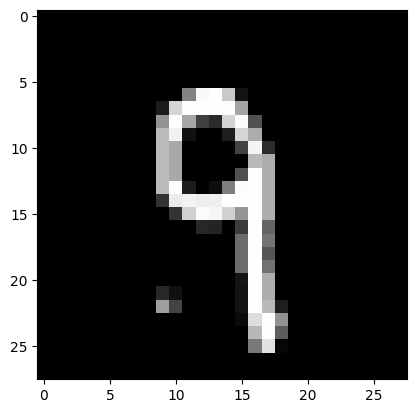

Prediction:  [7]
Label:  7


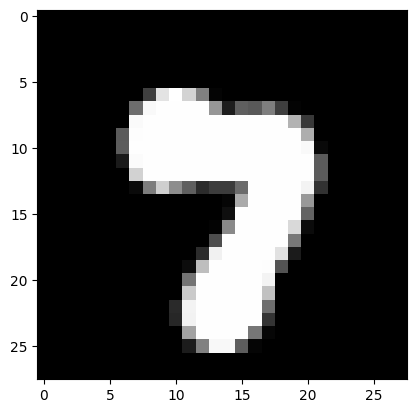

Prediction:  [9]
Label:  9


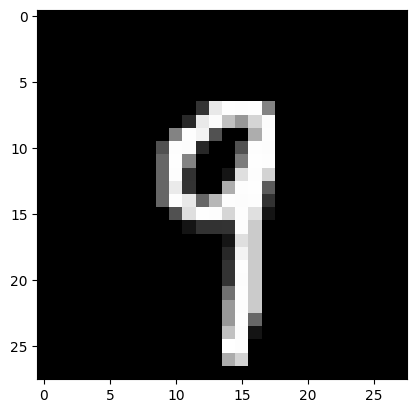

Prediction:  [1]
Label:  1


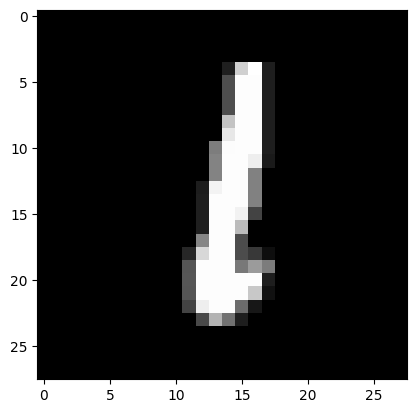

In [ ]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

Finally, let's find the accuracy on the dev set:

In [ ]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[7 9 1 3 5 0 0 5 8 7 0 8 2 2 9 9 8 9 9 6 7 3 6 8 5 6 7 4 5 5 8 1 3 0 4 0 2
 2 8 0 3 9 5 8 4 7 7 6 9 2 1 6 0 9 5 7 4 6 9 6 3 1 0 0 9 8 3 8 9 8 8 8 3 4
 3 8 4 2 4 3 6 4 6 4 8 6 3 1 7 6 4 3 2 8 8 9 2 6 7 3 6 4 0 5 0 2 1 1 8 3 6
 8 6 9 8 6 4 6 2 5 8 0 7 5 6 6 7 0 5 8 5 0 3 3 4 7 7 8 8 1 9 6 3 2 9 6 9 6
 6 3 3 7 9 2 0 0 4 1 6 5 0 0 4 7 6 9 8 9 3 0 2 8 5 0 8 8 4 1 8 2 8 0 2 1 6
 0 9 3 6 4 7 2 5 4 0 3 8 6 4 0 1 8 1 1 9 9 8 3 6 9 1 9 3 4 6 0 3 1 6 2 8 0
 2 1 5 3 7 5 5 3 1 2 8 9 0 0 8 0 1 0 6 8 8 0 2 7 9 2 7 2 3 5 9 0 5 0 9 5 3
 6 1 1 5 6 5 4 5 2 1 8 1 9 5 4 8 6 4 3 0 3 7 9 6 7 5 6 4 6 4 0 4 6 6 3 4 8
 2 2 3 0 1 2 6 0 0 0 0 4 5 6 1 5 6 6 1 3 4 1 9 6 1 9 8 9 8 6 4 8 3 3 2 1 2
 2 9 7 7 9 1 4 3 8 8 1 8 1 9 5 4 3 7 8 3 8 3 5 7 0 7 4 8 7 4 1 0 5 9 2 3 4
 8 4 9 8 0 0 9 0 2 4 9 3 7 0 7 5 3 1 7 2 9 7 1 7 0 9 7 6 5 1 9 0 7 1 9 1 0
 1 2 9 9 6 6 4 2 7 0 7 4 2 5 6 4 9 3 8 4 9 2 4 9 1 4 3 1 8 3 6 7 1 1 1 8 6
 8 2 2 2 9 0 0 7 6 0 3 8 6 3 3 5 6 9 2 1 2 1 4 2 5 5 7 2 8 6 2 1 5 5 0 4 3
 6 0 4 3 4 1 9 3 3 4 9 2 

np.float64(0.834)

Still 84% accuracy, so our model generalized from the training data pretty well.